In [24]:
from qiskit import QuantumRegister, QuantumCircuit
from itertools import combinations
from qiskit_aer import AerSimulator
from qiskit import transpile 
from qiskit.visualization import plot_histogram

In [25]:
def apply_gate(gate, inputs):
    if gate == 'AND':
        return inputs[0] and inputs[1]
    elif gate == 'OR':
        return inputs[0] or inputs[1]
    elif gate == 'XOR':
        return inputs[0] ^ inputs[1]
    elif gate == 'NAND':
        return not (inputs[0] and inputs[1])
    elif gate == 'NOR':
        return not (inputs[0] or inputs[1])
    elif gate == 'XNOR':
        return not (inputs[0] ^ inputs[1])
    elif gate == 'MCX':
        return all(inputs)
    else:
        raise ValueError(f"Unknown gate: {gate}")

def generate_truth_table(gates, num_inputs, aux_bits=1):
    num_combinations = 2 ** num_inputs
    truth_table = []

    # Calculate the required length of the output list
    #max_pos = max(max(pos) for _, pos in gates) + 1

    for i in range(num_combinations):
        inputs = [int(x) for x in bin(i)[2:].zfill(num_inputs)]
        output = inputs + [0] * aux_bits

        for gate, pos in gates:
            
            output[pos[-1]] = (output[pos[-1]] + apply_gate(gate, [output[i] for i in pos[0:-1]])) % 2
            #print(output, '/ inputs ', [output[i] for i in pos[0:-1]], '/', output[-1])
            
        truth_table.append((output))#inputs, output[max_pos - 1]))

    return truth_table

def print_truth_table(truth_table, num_inputs, mark_inputs=None):
    header = " | ".join([f"in{i}" for i in range(num_inputs)]) + " | out"
    print(header)
    print("-" * len(header))
    for row in truth_table:
        if mark_inputs is not None:
            if row[:-1] in mark_inputs:
                inputs = " | ".join(map(str, row))
                print(f"{inputs}  <<-----")
            else:
                inputs = " | ".join(map(str, row))
                print(f"{inputs}")
        else:
            inputs = " | ".join(map(str, row))
            print(f"{inputs}")


def apply_quantum_gate(qc, gate, inputs):
    if gate == 'AND':
        qc.ccx(*inputs)
    elif gate == 'XOR':
        qc.cx(inputs[0], inputs[2])
        qc.cx(inputs[1], inputs[2])
    elif gate == 'MCX':
        qc.mcx(list(inputs[:-1]), inputs[-1])

def create_quantum_circuit(gates, num_inputs):
    in_qubits = QuantumRegister(num_inputs, name='in')
    compare_qubits = QuantumRegister(1, name='cmp')

    qc = QuantumCircuit(in_qubits, compare_qubits)

    qc.h(in_qubits)

    for gate, inputs in gates:
        apply_quantum_gate(qc, gate, inputs)

    return qc


In [26]:
def generate_valid_combinations(elements, combination_size, forbidden_difference):
    
    # Function to check the condition of difference
    def difference_is_not_forbidden(combination):
        for a, b in combinations(combination, 2):
            if abs(a - b) == forbidden_difference:
                return False
        return True
    
    # Generate all possible combinations of the specified size
    valid_combinations = [
        combination for combination in combinations(elements, combination_size) 
        if difference_is_not_forbidden(combination)
    ]
    
    return valid_combinations

def modified_flipper(quantum_circuit, x, y, compare_register, tuple_index, color_size):
        x_qubits = list(range(x*color_size, (x+1)*color_size))
        y_qubits = list(range(y*color_size, (y+1)*color_size))
        xy_distance = abs(y - x)
        qubit_indices = x_qubits + y_qubits

        # Apply XOR gates qubitwise between the x_qubits and y_qubits
        for i in range(color_size):
            quantum_circuit.cx(x_qubits[i], compare_register[tuple_index])
            quantum_circuit.cx(y_qubits[i], compare_register[tuple_index])


        for i in range(2, color_size+1):
            combinations = generate_valid_combinations(qubit_indices, i, color_size*xy_distance)
            for comb in combinations:
                quantum_circuit.mcx(list(comb), compare_register[tuple_index])

In [27]:
# Define the gates and their positions
# Format: (gate, (input_position1, input_position2, output_position))
gates = [
    ('AND', (0, 1, 2)),
    ('AND', (0, 1, 2))
]

# Number of input bits
num_inputs = 2

# Generate the truth table
truth_table = generate_truth_table(gates, num_inputs)

# Print the truth table
print_truth_table(truth_table, num_inputs)

in0 | in1 | out
---------------
0 | 0 | 0
0 | 1 | 0
1 | 0 | 0
1 | 1 | 0


In [28]:
# Define the gates and their positions
# Format: (gate, (input_position1, input_position2, output_position))
gates = [
    ('XOR', (0, 2, 4)),
    ('XOR', (1, 3, 4)),

    ('AND', (0, 1, 4)),
    ('AND', (1, 2, 4)),
    ('AND', (2, 3, 4)),
    ('AND', (0, 3, 4))
]

# Number of input bits
num_inputs = 4
states = [[0, 0, 0, 0], [1, 0, 1, 0], [0, 1, 0, 1], [1, 1, 1, 1]]

# Generate the truth table
truth_table = generate_truth_table(gates, num_inputs)

# Print the truth table
print_truth_table(truth_table, num_inputs, mark_inputs=states)

in0 | in1 | in2 | in3 | out
---------------------------
0 | 0 | 0 | 0 | 0  <<-----
0 | 0 | 0 | 1 | 1
0 | 0 | 1 | 0 | 1
0 | 0 | 1 | 1 | 1
0 | 1 | 0 | 0 | 1
0 | 1 | 0 | 1 | 0  <<-----
0 | 1 | 1 | 0 | 1
0 | 1 | 1 | 1 | 1
1 | 0 | 0 | 0 | 1
1 | 0 | 0 | 1 | 1
1 | 0 | 1 | 0 | 0  <<-----
1 | 0 | 1 | 1 | 1
1 | 1 | 0 | 0 | 1
1 | 1 | 0 | 1 | 1
1 | 1 | 1 | 0 | 1
1 | 1 | 1 | 1 | 0  <<-----


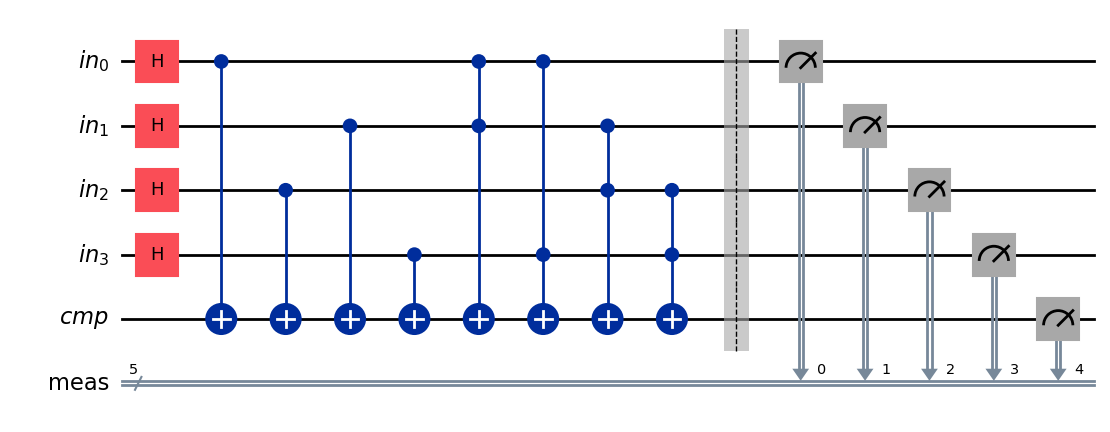

In [30]:
in_qubits = QuantumRegister(num_inputs, name='in')
compare_qubits = QuantumRegister(1, name='cmp')

qc = QuantumCircuit(in_qubits, compare_qubits)
qc.h(in_qubits)

modified_flipper(qc, x=0, y=1, compare_register=compare_qubits, tuple_index=0, color_size=2)
qc.measure_all()

qc.draw('mpl')


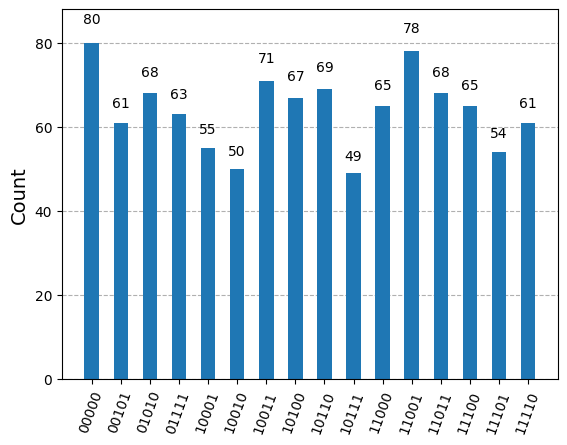

In [20]:
backend = AerSimulator()
qc_compiled = transpile(qc, backend)
job = backend.run(qc_compiled, shots=1024)
results = job.result()
counts = results.get_counts(qc_compiled)

plot_histogram(counts)

In [31]:
# Define the gates and their positions
# Format: (gate, (input_position1, input_position2, output_position))
gates = [
    ## Part 1
    ('XOR', (0, 3, 6)),
    ('XOR', (1, 4, 6)),
    ('XOR', (2, 5, 6)),

    ## Part 2
    ('AND', (0, 1, 6)),
    ('AND', (1, 2, 6)),
    ('AND', (2, 3, 6)),
    ('AND', (3, 4, 6)),
    ('AND', (4, 5, 6)),

    # Part 3
    ('AND', (0, 2, 6)),
    ('AND', (1, 3, 6)),
    ('AND', (2, 4, 6)),
    ('AND', (3, 5, 6)),
    
    # Part 4
    ('AND', (0, 4, 6)),
    ('AND', (1, 5, 6)),

    # Part 5
    ('AND', (0, 5, 6)),

    # Part 5
    ('MCX', (0, 1, 2, 6)),
    ('MCX', (1, 2, 3, 6)),
    ('MCX', (2, 3, 4, 6)),
    ('MCX', (3, 4, 5, 6)),
    ('MCX', (0, 2, 4, 6)),
    ('MCX', (1, 3, 5, 6)),
    ('MCX', (0, 4, 5, 6)),
    ('MCX', (0, 1, 5, 6)),
    
]

# Number of input bits
num_inputs = 6
states = [[0, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0, 0], [0, 1, 0, 0, 1, 0], [0, 0, 1, 0, 0, 1],
          [0, 1, 1, 0, 1, 1], [1, 0, 1, 1, 0, 1], [1, 1, 0, 1, 1, 0], [1, 1, 1, 1, 1, 1]]

# Generate the truth table
truth_table = generate_truth_table(gates, num_inputs)

# Print the truth table
print_truth_table(truth_table, num_inputs, mark_inputs=states)

in0 | in1 | in2 | in3 | in4 | in5 | out
---------------------------------------
0 | 0 | 0 | 0 | 0 | 0 | 0  <<-----
0 | 0 | 0 | 0 | 0 | 1 | 1
0 | 0 | 0 | 0 | 1 | 0 | 1
0 | 0 | 0 | 0 | 1 | 1 | 1
0 | 0 | 0 | 1 | 0 | 0 | 1
0 | 0 | 0 | 1 | 0 | 1 | 1
0 | 0 | 0 | 1 | 1 | 0 | 1
0 | 0 | 0 | 1 | 1 | 1 | 1
0 | 0 | 1 | 0 | 0 | 0 | 1
0 | 0 | 1 | 0 | 0 | 1 | 0  <<-----
0 | 0 | 1 | 0 | 1 | 0 | 1
0 | 0 | 1 | 0 | 1 | 1 | 1
0 | 0 | 1 | 1 | 0 | 0 | 1
0 | 0 | 1 | 1 | 0 | 1 | 1
0 | 0 | 1 | 1 | 1 | 0 | 1
0 | 0 | 1 | 1 | 1 | 1 | 1
0 | 1 | 0 | 0 | 0 | 0 | 1
0 | 1 | 0 | 0 | 0 | 1 | 1
0 | 1 | 0 | 0 | 1 | 0 | 0  <<-----
0 | 1 | 0 | 0 | 1 | 1 | 1
0 | 1 | 0 | 1 | 0 | 0 | 1
0 | 1 | 0 | 1 | 0 | 1 | 1
0 | 1 | 0 | 1 | 1 | 0 | 1
0 | 1 | 0 | 1 | 1 | 1 | 1
0 | 1 | 1 | 0 | 0 | 0 | 1
0 | 1 | 1 | 0 | 0 | 1 | 1
0 | 1 | 1 | 0 | 1 | 0 | 1
0 | 1 | 1 | 0 | 1 | 1 | 0  <<-----
0 | 1 | 1 | 1 | 0 | 0 | 1
0 | 1 | 1 | 1 | 0 | 1 | 1
0 | 1 | 1 | 1 | 1 | 0 | 1
0 | 1 | 1 | 1 | 1 | 1 | 1
1 | 0 | 0 | 0 | 0 | 0 | 1
1 | 0 | 0 | 0 | 0 | 1 | 1


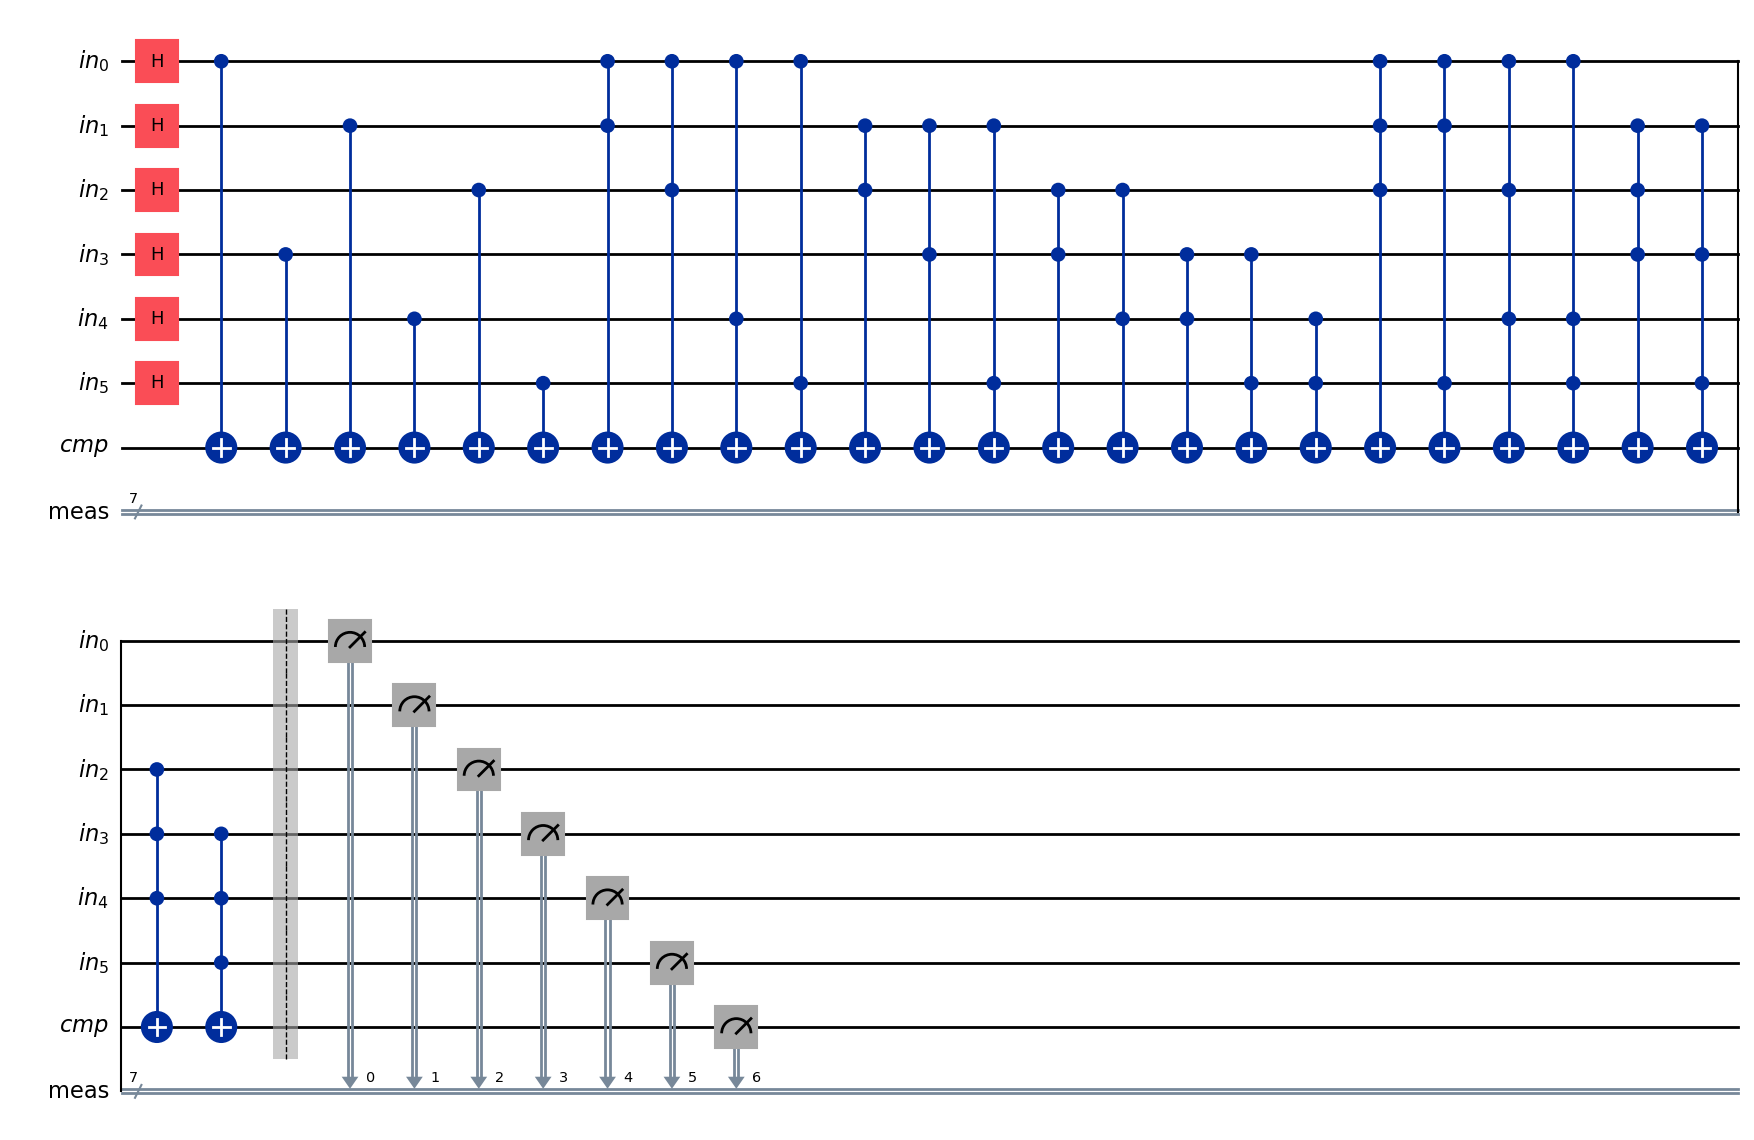

In [33]:
in_qubits = QuantumRegister(num_inputs, name='in')
compare_qubits = QuantumRegister(1, name='cmp')

qc = QuantumCircuit(in_qubits, compare_qubits)
qc.h(in_qubits)

modified_flipper(qc, x=0, y=1, compare_register=compare_qubits, tuple_index=0, color_size=3)
qc.measure_all()

qc.draw('mpl')


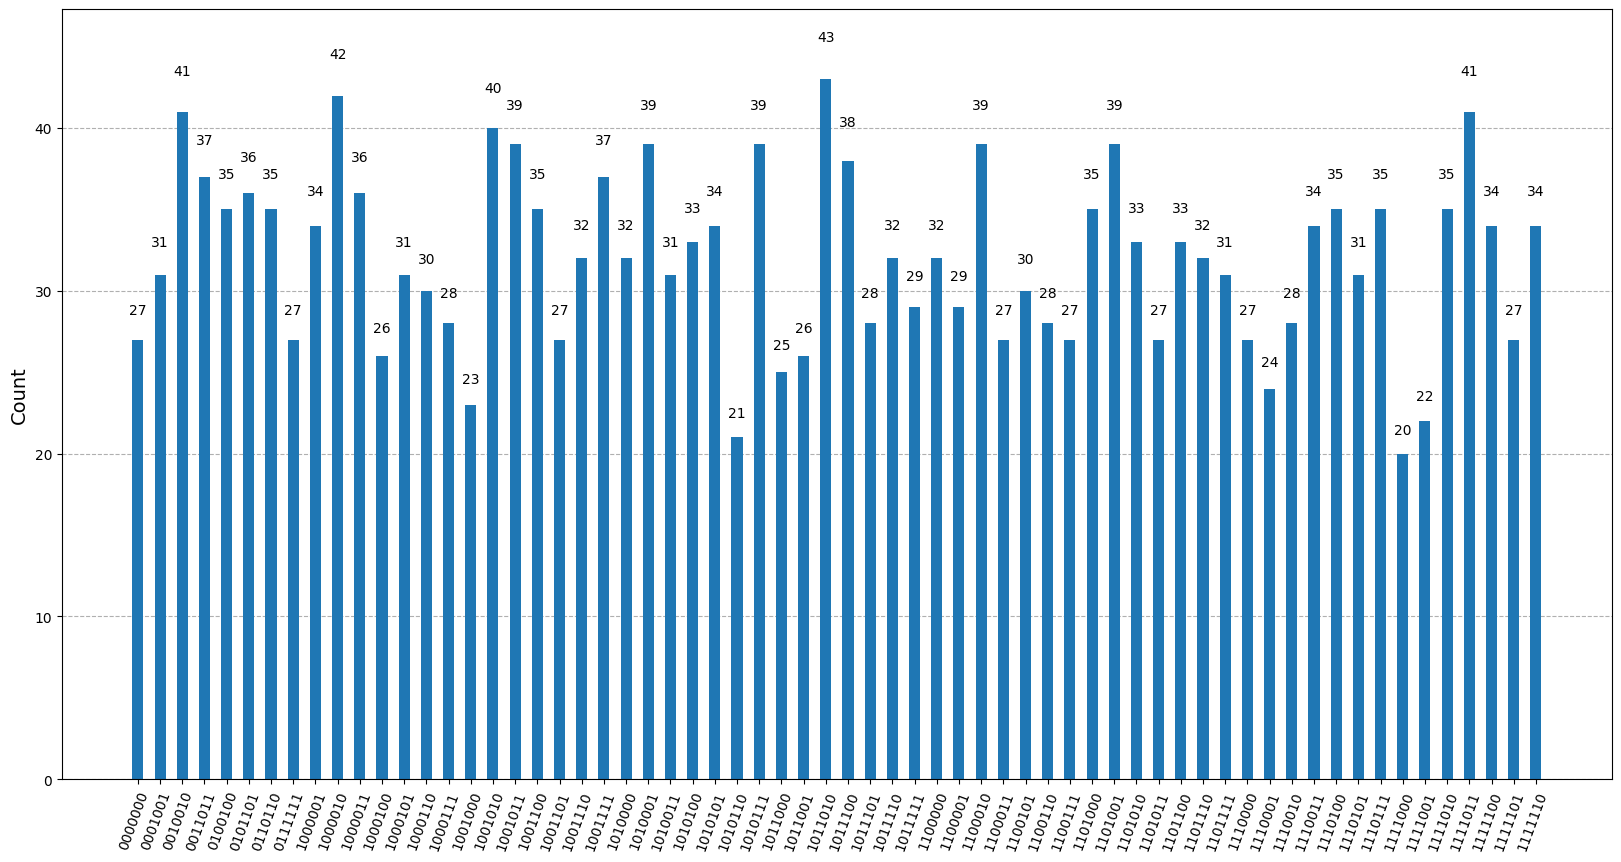

In [38]:
backend = AerSimulator()
qc_compiled = transpile(qc, backend)
job = backend.run(qc_compiled, shots=2048)
results = job.result()
counts = results.get_counts(qc_compiled)

plot_histogram(counts, figsize=(20, 10))

In [34]:
# Lista para almacenar las combinaciones de 8 bits
def generate_states(): 
    states = []

    # Iterar sobre todas las combinaciones posibles de 4 bits (de 0 a 15)
    for i in range(16):
        # Convertir el número a binario con relleno para asegurarse de tener 4 bits
        binario = f"{i:04b}"
        # Duplicar la combinación de 4 bits para obtener 8 bits
        combinacion_8_bits = [int(bit) for bit in binario] + [int(bit) for bit in binario]
        # Agregar la combinación de 8 bits a la lista
        states.append(combinacion_8_bits)
    
    return states


In [35]:
# Define the gates and their positions
# Format: (gate, (input_position1, input_position2, output_position))
gates = [
    ## Part 1
    ('XOR', (0, 4, 8)),
    ('XOR', (1, 5, 8)),
    ('XOR', (2, 6, 8)),
    ('XOR', (3, 7, 8)),

    ## Part 2
    ('AND', (0, 1, 8)),
    ('AND', (1, 2, 8)),
    ('AND', (2, 3, 8)),
    ('AND', (3, 4, 8)),
    ('AND', (4, 5, 8)),
    ('AND', (5, 6, 8)),
    ('AND', (6, 7, 8)),

    # Part 3
    ('AND', (0, 2, 8)),
    ('AND', (1, 3, 8)),
    ('AND', (2, 4, 8)),
    ('AND', (3, 5, 8)),
    ('AND', (4, 6, 8)),
    ('AND', (5, 7, 8)),

    # Part 4
    ('AND', (0, 3, 8)),
    ('AND', (1, 4, 8)),
    ('AND', (2, 5, 8)),
    ('AND', (3, 6, 8)),
    ('AND', (4, 7, 8)),

    # Part 5
    ('AND', (0, 5, 8)),
    ('AND', (1, 6, 8)),
    ('AND', (2, 7, 8)),

    # Part 6
    ('AND', (0, 6, 8)),
    ('AND', (1, 7, 8)),

    # Part 8
    ('AND', (0, 7, 8)),

    ('MCX', (0, 1, 2, 8)),
    ('MCX', (0, 1, 3, 8)),
    ('MCX', (0, 1, 6, 8)),
    ('MCX', (0, 1, 7, 8)),
    ('MCX', (0, 2, 3, 8)),
    ('MCX', (0, 2, 5, 8)),
    ('MCX', (0, 2, 7, 8)),
    ('MCX', (0, 3, 5, 8)),
    ('MCX', (0, 3, 6, 8)),
    ('MCX', (0, 5, 6, 8)),
    ('MCX', (0, 5, 7, 8)),
    ('MCX', (0, 6, 7, 8)),
    ('MCX', (1, 2, 3, 8)),
    ('MCX', (1, 2, 4, 8)),
    ('MCX', (1, 2, 7, 8)),
    ('MCX', (1, 3, 4, 8)),
    ('MCX', (1, 3, 6, 8)),
    ('MCX', (1, 4, 6, 8)),
    ('MCX', (1, 4, 7, 8)),
    ('MCX', (1, 6, 7, 8)),
    ('MCX', (2, 3, 4, 8)),
    ('MCX', (2, 3, 5, 8)),
    ('MCX', (2, 4, 5, 8)),
    ('MCX', (2, 4, 7, 8)),
    ('MCX', (2, 5, 7, 8)),
    ('MCX', (3, 4, 5, 8)),
    ('MCX', (3, 4, 6, 8)),
    ('MCX', (3, 5, 6, 8)),
    ('MCX', (4, 5, 6, 8)),
    ('MCX', (4, 5, 7, 8)),
    ('MCX', (4, 6, 7, 8)),
    ('MCX', (5, 6, 7, 8)),
    ('MCX', (0, 1, 2, 3, 8)),
    ('MCX', (1, 2, 4, 7, 8)),
    ('MCX', (0, 1, 2, 7, 8)),
    ('MCX', (0, 1, 3, 6, 8)),
    ('MCX', (0, 1, 6, 7, 8)),
    ('MCX', (0, 2, 3, 5, 8)),
    ('MCX', (0, 2, 5, 7, 8)),
    ('MCX', (0, 3, 5, 6, 8)),
    ('MCX', (0, 5, 6, 7, 8)),
    ('MCX', (1, 2, 3, 4, 8)),
    ('MCX', (1, 3, 4, 6, 8)),
    ('MCX', (1, 4, 6, 7, 8)),
    ('MCX', (2, 3, 4, 5, 8)),
    ('MCX', (2, 4, 5, 7, 8)),
    ('MCX', (3, 4, 5, 6, 8)),
    ('MCX', (4, 5, 6, 7, 8))
    
]

# Number of input bits
num_inputs = 8
states = generate_states()

# Generate the truth table
truth_table = generate_truth_table(gates, num_inputs)

# Print the truth table
print_truth_table(truth_table, num_inputs, mark_inputs=states)

in0 | in1 | in2 | in3 | in4 | in5 | in6 | in7 | out
---------------------------------------------------
0 | 0 | 0 | 0 | 0 | 0 | 0 | 0 | 0  <<-----
0 | 0 | 0 | 0 | 0 | 0 | 0 | 1 | 1
0 | 0 | 0 | 0 | 0 | 0 | 1 | 0 | 1
0 | 0 | 0 | 0 | 0 | 0 | 1 | 1 | 1
0 | 0 | 0 | 0 | 0 | 1 | 0 | 0 | 1
0 | 0 | 0 | 0 | 0 | 1 | 0 | 1 | 1
0 | 0 | 0 | 0 | 0 | 1 | 1 | 0 | 1
0 | 0 | 0 | 0 | 0 | 1 | 1 | 1 | 1
0 | 0 | 0 | 0 | 1 | 0 | 0 | 0 | 1
0 | 0 | 0 | 0 | 1 | 0 | 0 | 1 | 1
0 | 0 | 0 | 0 | 1 | 0 | 1 | 0 | 1
0 | 0 | 0 | 0 | 1 | 0 | 1 | 1 | 1
0 | 0 | 0 | 0 | 1 | 1 | 0 | 0 | 1
0 | 0 | 0 | 0 | 1 | 1 | 0 | 1 | 1
0 | 0 | 0 | 0 | 1 | 1 | 1 | 0 | 1
0 | 0 | 0 | 0 | 1 | 1 | 1 | 1 | 1
0 | 0 | 0 | 1 | 0 | 0 | 0 | 0 | 1
0 | 0 | 0 | 1 | 0 | 0 | 0 | 1 | 0  <<-----
0 | 0 | 0 | 1 | 0 | 0 | 1 | 0 | 1
0 | 0 | 0 | 1 | 0 | 0 | 1 | 1 | 1
0 | 0 | 0 | 1 | 0 | 1 | 0 | 0 | 1
0 | 0 | 0 | 1 | 0 | 1 | 0 | 1 | 1
0 | 0 | 0 | 1 | 0 | 1 | 1 | 0 | 1
0 | 0 | 0 | 1 | 0 | 1 | 1 | 1 | 1
0 | 0 | 0 | 1 | 1 | 0 | 0 | 0 | 1
0 | 0 | 0 | 1 | 1 | 0 | 0 | 

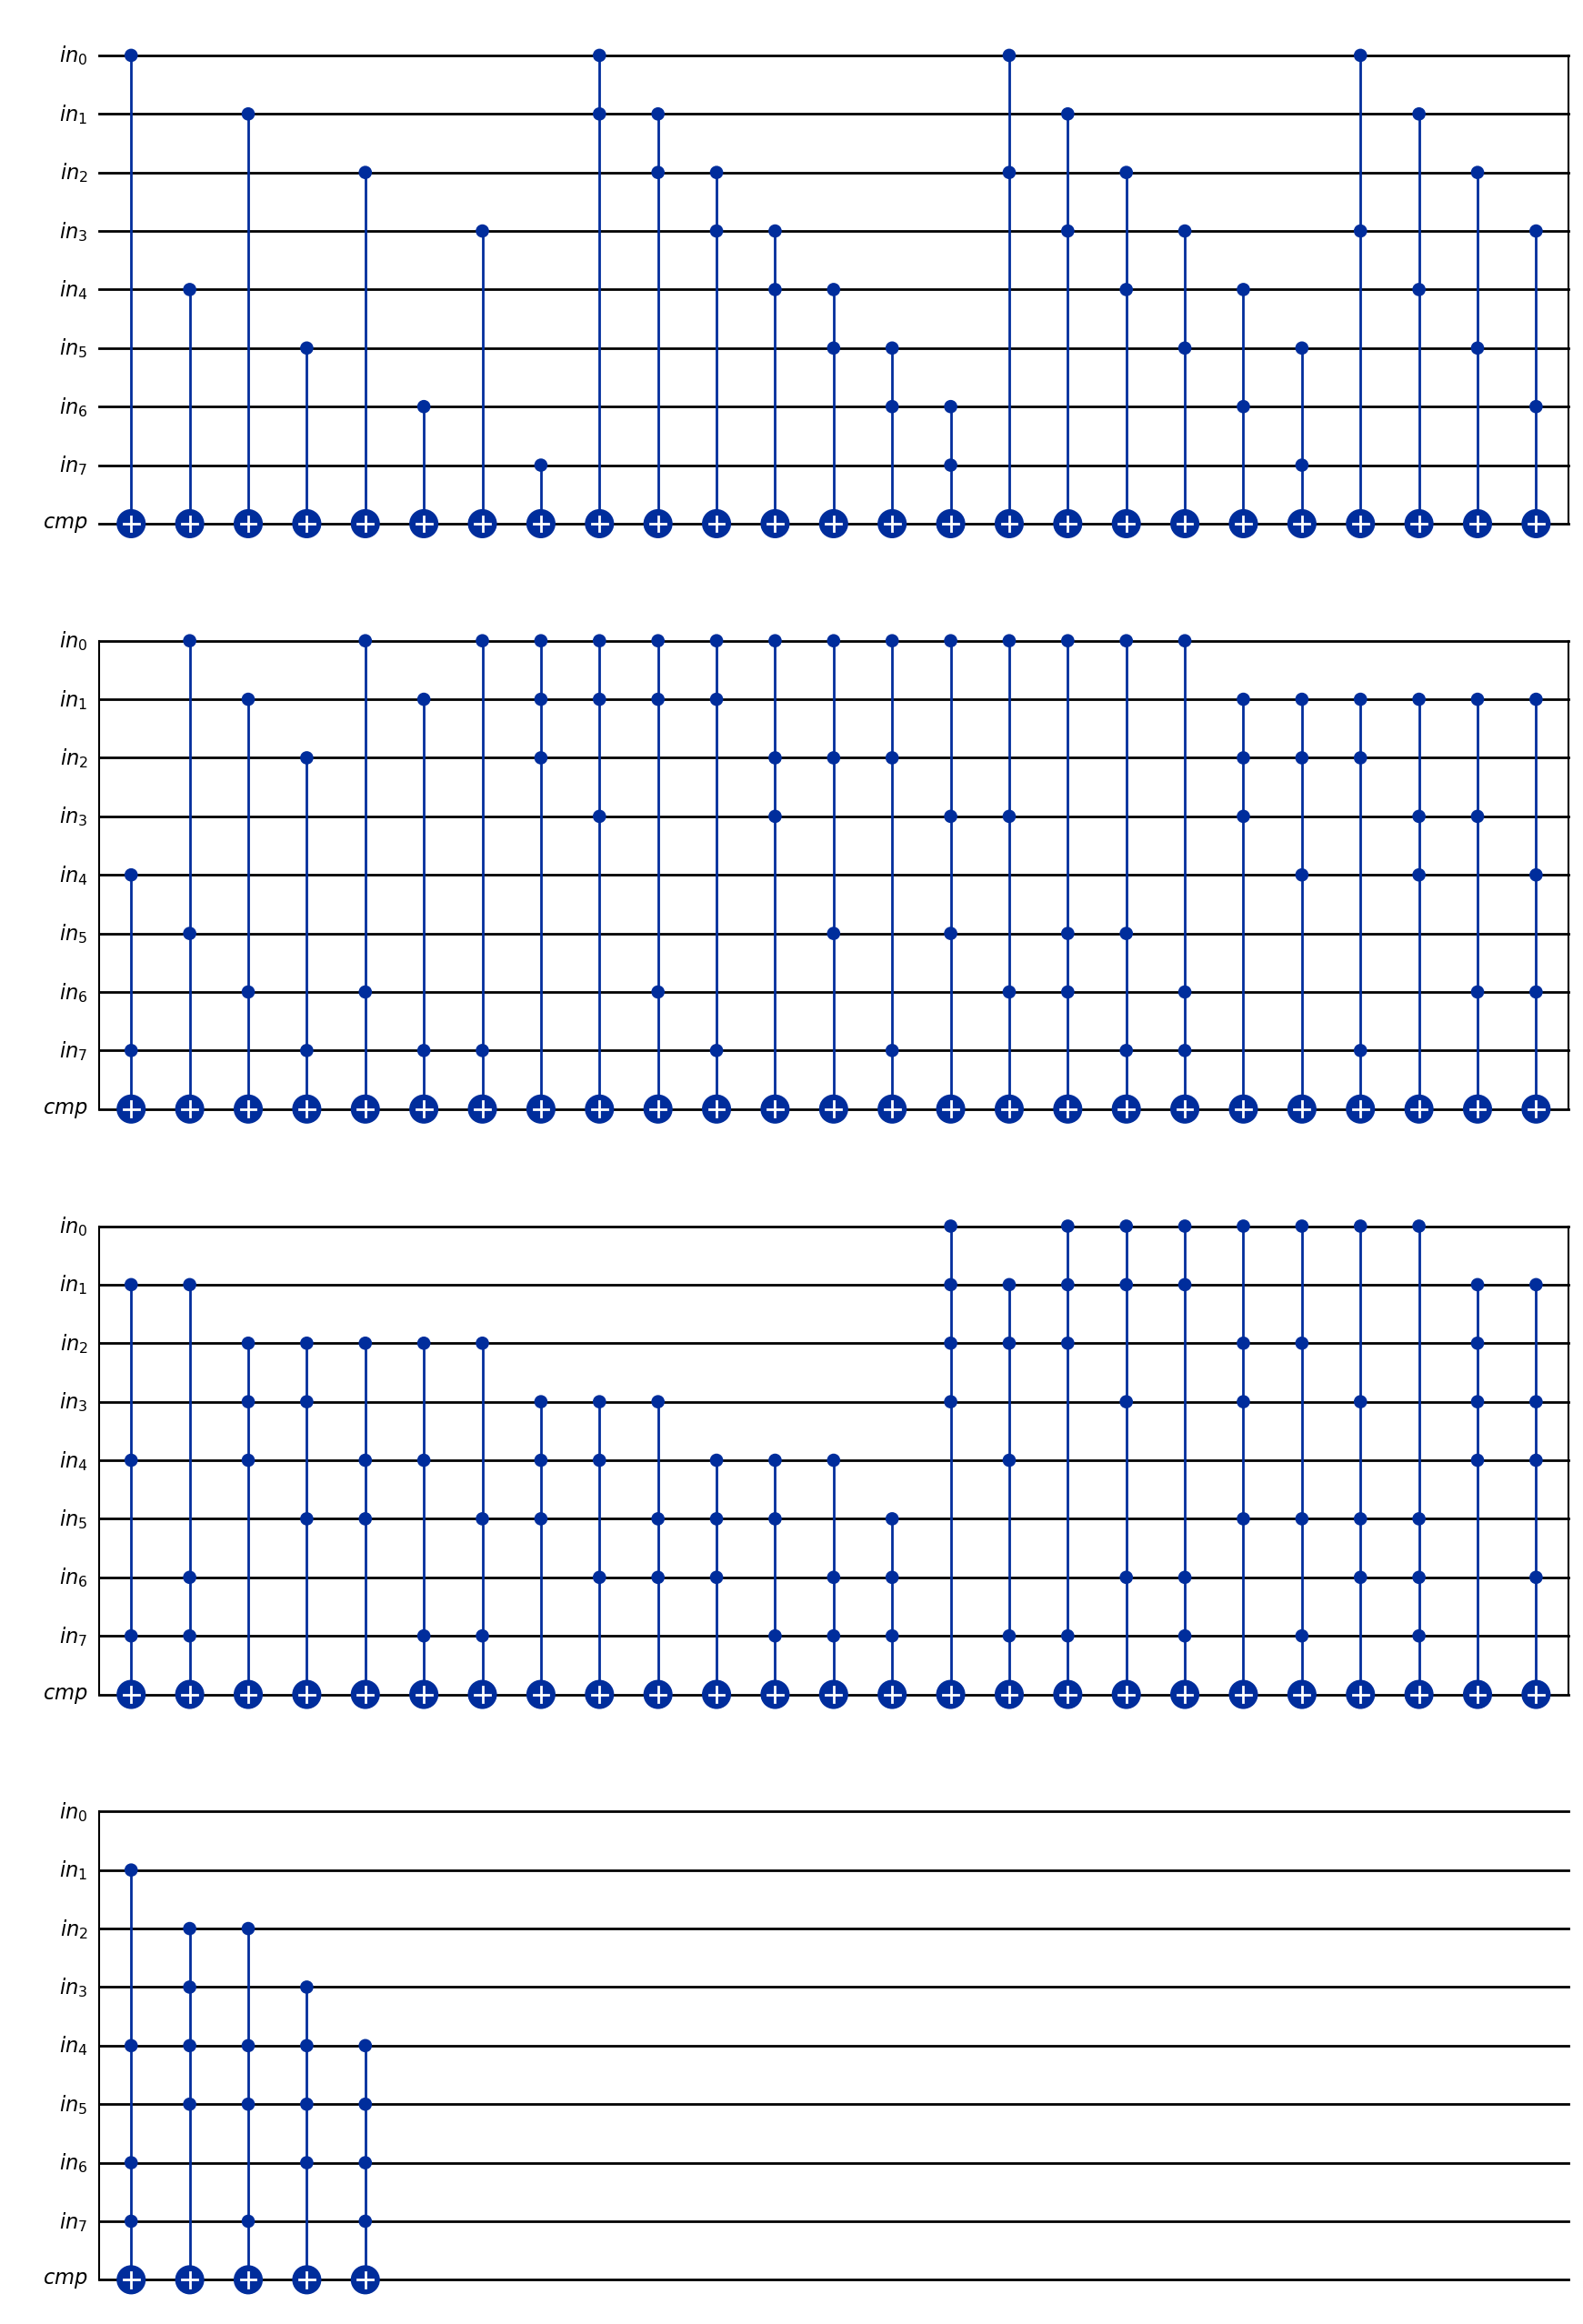

In [12]:
qc = print_quantum_circuit(gates, num_inputs)
qc.draw('mpl')

(0, 1, 2)
(0, 1, 3)
(0, 1, 6)
(0, 1, 7)
(0, 2, 3)
(0, 2, 5)
(0, 2, 7)
(0, 3, 5)
(0, 3, 6)
(0, 5, 6)
(0, 5, 7)
(0, 6, 7)
(1, 2, 3)
(1, 2, 4)
(1, 2, 7)
(1, 3, 4)
(1, 3, 6)
(1, 4, 6)
(1, 4, 7)
(1, 6, 7)
(2, 3, 4)
(2, 3, 5)
(2, 4, 5)
(2, 4, 7)
(2, 5, 7)
(3, 4, 5)
(3, 4, 6)
(3, 5, 6)
(4, 5, 6)
(4, 5, 7)
(4, 6, 7)
(5, 6, 7)


In [14]:
t = []
for comb in combinaciones:
    gate = ('MCX', comb+(8,))
    t.append(gate)

t

[('MCX', (0, 1, 2, 8)),
 ('MCX', (0, 1, 3, 8)),
 ('MCX', (0, 1, 6, 8)),
 ('MCX', (0, 1, 7, 8)),
 ('MCX', (0, 2, 3, 8)),
 ('MCX', (0, 2, 5, 8)),
 ('MCX', (0, 2, 7, 8)),
 ('MCX', (0, 3, 5, 8)),
 ('MCX', (0, 3, 6, 8)),
 ('MCX', (0, 5, 6, 8)),
 ('MCX', (0, 5, 7, 8)),
 ('MCX', (0, 6, 7, 8)),
 ('MCX', (1, 2, 3, 8)),
 ('MCX', (1, 2, 4, 8)),
 ('MCX', (1, 2, 7, 8)),
 ('MCX', (1, 3, 4, 8)),
 ('MCX', (1, 3, 6, 8)),
 ('MCX', (1, 4, 6, 8)),
 ('MCX', (1, 4, 7, 8)),
 ('MCX', (1, 6, 7, 8)),
 ('MCX', (2, 3, 4, 8)),
 ('MCX', (2, 3, 5, 8)),
 ('MCX', (2, 4, 5, 8)),
 ('MCX', (2, 4, 7, 8)),
 ('MCX', (2, 5, 7, 8)),
 ('MCX', (3, 4, 5, 8)),
 ('MCX', (3, 4, 6, 8)),
 ('MCX', (3, 5, 6, 8)),
 ('MCX', (4, 5, 6, 8)),
 ('MCX', (4, 5, 7, 8)),
 ('MCX', (4, 6, 7, 8)),
 ('MCX', (5, 6, 7, 8))]

In [15]:
# Definir dos tuplas
tupla1 = (0, 1, 2)
tupla2 = (3, 4, 5)

# Unir las tuplas
tupla_unida = tupla1 + tupla2

# Mostrar la nueva tupla
print("Tupla 1:", tupla1)
print("Tupla 2:", tupla2)
print("Tupla unida:", tupla_unida)


Tupla 1: (0, 1, 2)
Tupla 2: (3, 4, 5)
Tupla unida: (0, 1, 2, 3, 4, 5)
